# 1. Imports and setup

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pathlib
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50

import itertools

## Step 0: Check GPU

In [15]:
# check GPU
tf.test.is_gpu_available()

True

## Step 1: Download Data



In [16]:
workspace_dir = '.'

# gdown is a package that downloads files from google drive
!gdown --id 1YF02tfgWKS6jRyWBKJoHkJ83KZvgl_u4 \
    --output "{workspace_dir}/alzheimer-brain-mri.zip"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1YF02tfgWKS6jRyWBKJoHkJ83KZvgl_u4
To: /content/alzheimer-brain-mri.zip
100% 29.0M/29.0M [00:00<00:00, 265MB/s]


### Decompress the dataset

In [17]:
import zipfile

data_dir = "kaggle/input/alzheimer-mri-dataset/Dataset/"
path_dir = pathlib.Path("kaggle/input/alzheimer-mri-dataset/Dataset/") 

with zipfile.ZipFile("alzheimer-brain-mri.zip", 'r') as zip_ref:
    zip_ref.extractall(data_dir)

class_names = np.array(sorted([item.name for item in path_dir.glob('*')]))
print(class_names)

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']


# 2. Explore individual images

In [18]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    return img

Image shape: (128, 128)


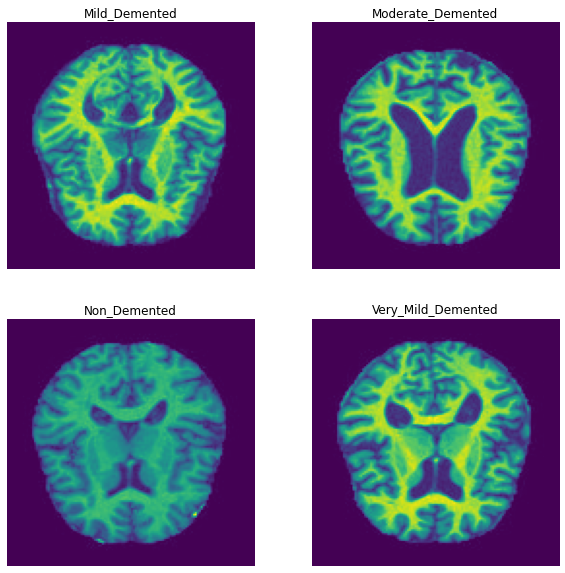

In [19]:
plt.figure(figsize=(10, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = view_random_image(data_dir, class_names[i])
print(f"Image shape: {img.shape}")

# 3. Model Tuning

## Split and preprocess data

In [20]:
# For replicable results
SEED = 0
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 16
# Images are rgb
COLOR_MODE = "rgb"
# 20% test split
VAL_SPLIT = 0.2

tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Model creation and compilation (ResNet50)

In [21]:
# cannot use the imagenet weights whith single channel images.
net = ResNet50(include_top=False, # 是否包含最後的全連接層 (fully-connected layer)
              weights=None, # None: 權重隨機初始化、'imagenet': 載入預訓練權重
              input_shape=(IMAGE_SIZE+(3,))) #(128,128,3)
x = net.layers[-1].output # 因為 include_top=False ，模型需要補上 output layer
x = Flatten(name='flatten')(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(len(class_names), activation='softmax', name='softmax')(x)

model = Model(inputs=net.input, outputs=output_layer)

# Default Learning rate
LR = 1e-4

model.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=["accuracy"])

## Fit and evaluate model

In [9]:
checkpoint_filepath = 'weights/weights.{epoch:02d}-{val_accuracy:.2f}.h5'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

# Epochs
EPOCHS = 50
history = model.fit(train_data,
          validation_data=valid_data,
          epochs=EPOCHS,
          callbacks=[cp_callback])

Epoch 1/50
320/320 [==============================] - 43s 86ms/step - loss: 2.7457 - accuracy: 0.4363 - val_loss: 1.3160 - val_accuracy: 0.4953
Epoch 2/50
320/320 [==============================] - 26s 80ms/step - loss: 2.1794 - accuracy: 0.4941 - val_loss: 2.8983 - val_accuracy: 0.3836
Epoch 3/50
320/320 [==============================] - 27s 85ms/step - loss: 2.0193 - accuracy: 0.5361 - val_loss: 3.2629 - val_accuracy: 0.5617
Epoch 4/50
320/320 [==============================] - 27s 85ms/step - loss: 1.5566 - accuracy: 0.5795 - val_loss: 1.3204 - val_accuracy: 0.6117
Epoch 5/50
320/320 [==============================] - 26s 82ms/step - loss: 1.2191 - accuracy: 0.6213 - val_loss: 1.2893 - val_accuracy: 0.6039
Epoch 6/50
320/320 [==============================] - 27s 86ms/step - loss: 0.9626 - accuracy: 0.6902 - val_loss: 0.7751 - val_accuracy: 0.6820
Epoch 7/50
320/320 [==============================] - 26s 82ms/step - loss: 0.7433 - accuracy: 0.7586 - val_loss: 5.6138 - val_accuracy:

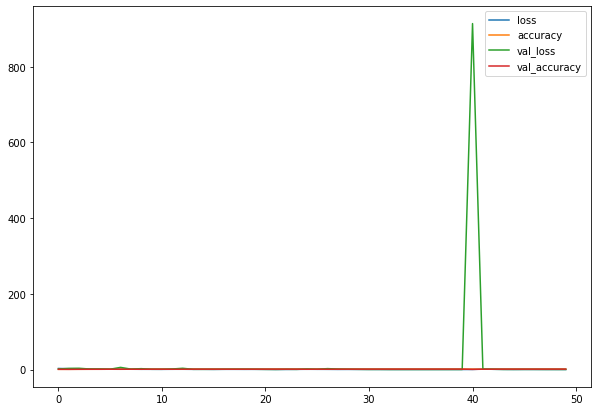

In [10]:
pd.DataFrame(history.history).plot(figsize=(10, 7))

load the weights from the checkpoint and re-evaluate

In [13]:
# Loads the weights
weight_path = "/content/weights/weights.38-0.98.h5"
model.load_weights(weight_path)

# Re-evaluate the model
loss, acc = model.evaluate(valid_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

80/80 - 2s - loss: 0.0757 - accuracy: 0.9797 - 2s/epoch - 24ms/step
Restored model, accuracy: 97.97%
